## Problem 2: Recurrent Neural Networks (30 points)

Here we will work on several problems in recurrent neural networks and NLP. First, you should
just play with word embeddings to get a greater understanding of what they are and how they
work (and when normalized and unnormalized vectors are better).

<font color=blue>
Mostly for technical reasons (my GPU goes OOM when I try), I'm using the moving dataset with the NLP and the simple dataset with the RNN.  The question answers are located at the bottom of this document.
</font>

In [1]:
# Download word vectors
from urllib.request import urlretrieve
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
if not os.path.isfile('mini.h5'):
    print("Downloading Conceptnet Numberbatch word embeddings...")
    conceptnet_url = 'http://conceptnet.s3.amazonaws.com/precomputed-data/2016/numberbatch/17.06/mini.h5'
    urlretrieve(conceptnet_url, 'mini.h5')

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import h5py
with h5py.File('mini.h5', 'r') as f:
    all_words = [word.decode('utf-8') for word in f['mat']['axis1'][:]]
    all_embeddings = f['mat']['block0_values'][:]

In [3]:
english_words = [word[6:] for word in all_words if word.startswith('/c/en/')]
english_word_indices = [i for i, word in enumerate(all_words) if word.startswith('/c/en/')]
english_embedddings = all_embeddings[english_word_indices] 

In [4]:
norms = np.linalg.norm(english_embedddings, axis=1)
normalized_embeddings = english_embedddings.astype('float32') / norms.astype('float32').reshape([-1, 1]) 

In [5]:
index = {word: i for i, word in enumerate(english_words)} 

In [7]:
#Let's pull our data from the Movie Review .txt

import string
remove_punct=str.maketrans('','',string.punctuation)

# This function converts a line of our data file into
# a tuple (x, y), where x is 300-dimensional representation
# of the words in a review, and y is its label.
def convert_line_to_ex(line):
    # Pull out the first character: that's our label (0 or 1)
    y = int(line[0])
    # Split the line into words using Python's split() function
    words = line[2:].translate(remove_punct).lower().split()
    # Look up the embeddings of each word, ignoring words not
    # in our pretrained vocabulary.
    embeddings = [normalized_embeddings[index[w]] for w in words
                  if w in index]
    # Take the mean of the embeddings
    x = np.mean(np.vstack(embeddings), axis=0)
    return {'x': x, 'y': y}

# Apply the function to each line in the file.
enc = 'utf-8' # This is necessary from within the singularity shell
with open("movie-pang02.txt", "r", encoding=enc) as f:
    dataset = [convert_line_to_ex(l) for l in f.readlines()]

In [8]:
import random
random.shuffle(dataset)

batch_size = 100
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:] 

    (i) Train an MLP off of the average word embedding to predict sentiment (as done in class) but
    optimize the network settings to maximize performance

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

In [22]:
tf.reset_default_graph()

# Placeholders for input
X = tf.placeholder(tf.float32, [None, 300])
y = tf.placeholder(tf.float32, [None, 1])

# Three-layer MLP
h1 = tf.layers.dense(X, 100, tf.nn.relu)
h2 = tf.layers.dense(h1, 20, tf.nn.relu)
logits = tf.layers.dense(h2, 1)
probabilities = tf.sigmoid(logits)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(logits)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(.001).minimize(loss)

# Initialization of variables
initialize_all = tf.global_variables_initializer() 

In [23]:
#Run training
train_acc = []
test_acc = []

sess = tf.InteractiveSession()
sess.run(initialize_all)
for epoch in range(200):
    for batch in range(train_batches):
        data = train[batch*batch_size:(batch+1)*batch_size]
        reviews = [sample['x'] for sample in data]
        labels  = [sample['y'] for sample in data]
        labels = np.array(labels).reshape([-1, 1])
        _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
    if epoch % 10 == 0:
        train_acc.append(acc)
        test_reviews = [sample['x'] for sample in test]
        test_labels  = [sample['y'] for sample in test]
        test_labels = np.array(test_labels).reshape([-1, 1])
        acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
        test_acc.append(acc)
        print(epoch)
        #print("Epoch", epoch, "Loss", l, "Acc", acc)
    random.shuffle(train)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


Final accuracy: 0.794


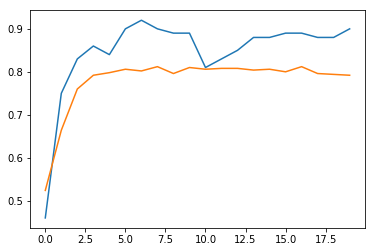

In [24]:
# Evaluate on test set
test_reviews = [sample['x'] for sample in test]
test_labels  = [sample['y'] for sample in test]
test_labels = np.array(test_labels).reshape([-1, 1])
acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
sess.close()
print("Final accuracy:", acc)

plt.plot(range(len(train_acc)),train_acc,range(len(train_acc)),test_acc)
plt.show()

In [25]:
#try_l1 = [200,150,100,75,50]
#try_l2 = [60,40,20,10,5]
#for l1 in try_l1:
#for l2 in try_l2
for _ in range(5):
    tf.reset_default_graph()

    # Placeholders for input
    X = tf.placeholder(tf.float32, [None, 300])
    y = tf.placeholder(tf.float32, [None, 1])

    # Three-layer MLP
    h1 = tf.layers.dense(X, 100, tf.nn.relu)
    h2 = tf.layers.dense(h1, 20, tf.nn.relu)
    logits = tf.layers.dense(h2, 1)
    probabilities = tf.sigmoid(logits)

    # Loss and metrics
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(logits)), y), tf.float32))

    # Training
    train_step = tf.train.AdamOptimizer().minimize(loss)

    # Initialization of variables
    initialize_all = tf.global_variables_initializer() 

    sess = tf.InteractiveSession()
    sess.run(initialize_all)
    for epoch in range(200):
        for batch in range(train_batches):
            data = train[batch*batch_size:(batch+1)*batch_size]
            reviews = [sample['x'] for sample in data]
            labels  = [sample['y'] for sample in data]
            labels = np.array(labels).reshape([-1, 1])
            _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})

    test_reviews = [sample['x'] for sample in test]
    test_labels  = [sample['y'] for sample in test]
    test_labels = np.array(test_labels).reshape([-1, 1])
    acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
    sess.close()
    print("acc:", acc)
    

acc: 0.792
acc: 0.8
acc: 0.798
acc: 0.798
acc: 0.794


    Moving forward,  let's just use AdamOptimizer and the half the initial sizes the layering.

    (ii) Train a RNN from the word embeddings to predict sentiment (as done in class) and optimize
    the network settings to maximize performance.

In [26]:
#Let's pull our data from the Movie Review .txt
remove_punct=str.maketrans('','',string.punctuation)

def convert_line_to_embed(line):
    y = int(line[0])
    words = line[2:].translate(remove_punct).lower().split()
    
    #We're going to repull the data, but just use the embeddings
    embeddings = [normalized_embeddings[index[w]] for w in words
                  if w in index]
    return {'y': y, 'x':embeddings}

# Apply the function to each line in the file.
enc = 'utf-8' # This is necessary from within the singularity shell
with open("movie-simple.txt", "r", encoding=enc) as f:
    dataset = [convert_line_to_embed(l) for l in f.readlines()]

In [27]:
random.shuffle(dataset)
batch_size = 1
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]

In [46]:
tf.reset_default_graph()
    
# sizes
n_steps = None
n_inputs = 300
n_neurons = 100

# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y= tf.placeholder(tf.float32, [None, 1])
basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
last_cell_output=outputs[:,-1,:]
y_=tf.layers.dense(last_cell_output,1)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(y_)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)
initialize_all = tf.global_variables_initializer()

In [47]:
sess = tf.InteractiveSession()
sess.run(initialize_all)
l_ma=.74
acc_ma=.5
for epoch in range(6):
    for batch in range(train_batches):
        data = train[batch*batch_size:(batch+1)*batch_size]
        reviews = np.array([sample['x'] for sample in data]).reshape([1,-1,n_inputs])
        labels  = np.array([sample['y'] for sample in data]).reshape([1,1])
        labels = np.array(labels).reshape([-1, 1])
        _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
        l_ma=.99*l_ma+(.01)*l
        acc_ma=.99*acc_ma+(.01)*acc
        if (batch+1) % 100 == 0:
            print("batch", batch, "Loss", l_ma, "Acc", acc_ma)
    
    #On every epoch    
    test_acc=0
    n=0
    for sample in test:
        test_reviews = np.array([sample['x']]).reshape([1,-1,n_inputs])
        test_labels  = np.array([sample['y']]).reshape([1,1])
        test_labels = np.array(test_labels).reshape([-1, 1])
        test_acc += sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
        n+=1
    acc=test_acc/n 

    print("Epoch", epoch, "Test Accuracy", acc)
        
    random.shuffle(train)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


batch 99 Loss 0.6812529462154145 Acc 0.562209809641149
batch 199 Loss 0.6464796067140935 Acc 0.6500341528217551
batch 299 Loss 0.6012796949698598 Acc 0.698219791972338
batch 399 Loss 0.5341334609809568 Acc 0.7873857811984872
batch 499 Loss 0.44009819237975994 Acc 0.8543478564637345
batch 599 Loss 0.4228448561653151 Acc 0.8714832393511676
batch 699 Loss 0.4338927792414936 Acc 0.8689004927673253
batch 799 Loss 0.4490734083564355 Acc 0.8215628439541967
batch 899 Loss 0.4738998468075115 Acc 0.8147187175054778
batch 999 Loss 0.38936516222584255 Acc 0.867774737048057
Epoch 0 Test Accuracy 0.9065155807365439
batch 99 Loss 0.24147058774772928 Acc 0.9151625568185527
batch 199 Loss 0.2152916207587572 Acc 0.931914050623356
batch 299 Loss 0.2622331786745472 Acc 0.8894132668817529
batch 399 Loss 0.25106660052047763 Acc 0.9096636870309908
batch 499 Loss 0.17573437686811044 Acc 0.9420561437141728
batch 599 Loss 0.1609973229044352 Acc 0.9462397499673143
batch 699 Loss 0.1736110972727284 Acc 0.94457567

    We're going with the LSTM RNN setup.  We're also upping the number of epochs

    (iii) Encode each vocabulary word as a one-hot vector. Train an MLP on the average of the onehot
    vectors

In [48]:
dataset = []
#Let's build that one hot encoded dataset
#We're runnign the more difficult review set again for the MLP
with open("movie-pang02.txt", "r", encoding=enc) as f:
    
    vocab_list = []
    all_lines = []
    
    labels = []
    
    #Creates a vocabulary list from the text
    for count, line in enumerate(f.readlines()):
        labels.append(int(line[0]))
        words = line[2:].translate(remove_punct).lower().split()
        all_lines.append(words)
        for word in words:
            if word not in vocab_list:
                vocab_list.append(word)
        if count%100 == 0:
            print(count)
        
    print("list built")
    one_hots = np.zeros(len(vocab_list))
    
    #Gets the averaged one_hot encodings
    for l, line in enumerate(all_lines):
        embeddings = []
        for word in line:
            one_hots[vocab_list.index(word)] += 1
        one_hots = one_hots/sum(one_hots)
        dataset.append({'x': one_hots, 'y': labels[l]})
        if l%100 == 0:
            print(l)
    
    print("Dataset built ",len(dataset))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
list built
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Dataset built  2000


In [49]:
random.shuffle(dataset)

batch_size = 100
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:] 

x_size = len(vocab_list)
print(x_size)

39856


In [50]:
tf.reset_default_graph()

# Placeholders for input
X = tf.placeholder(tf.float32, [None, x_size])
y = tf.placeholder(tf.float32, [None, 1])

# Three-layer MLP
h1 = tf.layers.dense(X, 50, tf.nn.relu)
h2 = tf.layers.dense(h1, 10, tf.nn.relu)
logits = tf.layers.dense(h2, 1)
probabilities = tf.sigmoid(logits)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(logits)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(.001).minimize(loss)

# Initialization of variables
initialize_all = tf.global_variables_initializer() 

In [51]:
#Run training
train_acc = []
test_acc = []

sess = tf.InteractiveSession()
sess.run(initialize_all)
for epoch in range(20):
    for batch in range(train_batches):
        data = train[batch*batch_size:(batch+1)*batch_size]
        reviews = [sample['x'] for sample in data]
        labels  = [sample['y'] for sample in data]
        labels = np.array(labels).reshape([-1, 1])
        _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
    if epoch % 2 == 0:
        train_acc.append(acc)
        test_reviews = [sample['x'] for sample in test]
        test_labels  = [sample['y'] for sample in test]
        test_labels = np.array(test_labels).reshape([-1, 1])
        acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
        test_acc.append(acc)
        print("Epoch ",epoch)
        #print("Epoch", epoch, "Loss", l, "Acc", acc)
    random.shuffle(train)

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch  0
Epoch  2
Epoch  4
Epoch  6
Epoch  8
Epoch  10
Epoch  12
Epoch  14
Epoch  16
Epoch  18


Final accuracy: 0.888


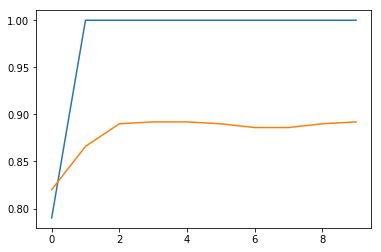

In [52]:
# Evaluate on test set
test_reviews = [sample['x'] for sample in test]
test_labels  = [sample['y'] for sample in test]
test_labels = np.array(test_labels).reshape([-1, 1])
acc = sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
sess.close()
print("Final accuracy:", acc)

plt.plot(range(len(train_acc)),train_acc,range(len(train_acc)),test_acc)
plt.show()

    (iv) As in (iii), but use an RNN on the one-hot encodings.

In [64]:
dataset = []
#Let's build that one hot encoded dataset
with open("movie-simple.txt", "r", encoding=enc) as f:
    
    vocab_list = []
    all_lines = []
    
    labels = []
    
    for count, line in enumerate(f.readlines()):
        labels.append(int(line[0]))
        words = line[2:].translate(remove_punct).lower().split()
        all_lines.append(words)
        for word in words:
            if word not in vocab_list:
                vocab_list.append(word)
        if count%100 == 0:
            print(count)
        
    print("list built")
    one_hots = []
    for l, line in enumerate(all_lines):
        one_hots = []
        for word in line:
            one_hot = np.zeros(len(vocab_list))
            one_hot[vocab_list.index(word)] += 1
            one_hots.append(one_hot)
        dataset.append({'x': one_hots, 'y': labels[l]})
        if l%100 == 0:
            print(l)
    
    print("Dataset built ",len(dataset))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
list built
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
Dataset built  1411


In [65]:
random.shuffle(dataset)
batch_size = 1
total_batches = len(dataset) // batch_size
train_batches = 3 * total_batches // 4
train, test = dataset[:train_batches*batch_size], dataset[train_batches*batch_size:]

In [66]:
tf.reset_default_graph()
    
# sizes
n_steps = None
n_inputs = len(vocab_list)
n_neurons = 150

# Build RNN
X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y= tf.placeholder(tf.float32, [None, 1])
basic_cell = tf.contrib.rnn.LSTMCell(n_neurons,activation=tf.nn.tanh)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
last_cell_output=outputs[:,-1,:]
y_=tf.layers.dense(last_cell_output,1)

# Loss and metrics
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_, labels=y))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(y_)), y), tf.float32))

# Training
train_step = tf.train.AdamOptimizer(0.0005).minimize(loss)
initialize_all = tf.global_variables_initializer()

In [67]:
#Run training
sess = tf.InteractiveSession()
sess.run(initialize_all)
l_ma=.74
acc_ma=.5
for epoch in range(5):
    for batch in range(train_batches):
        data = train[batch*batch_size:(batch+1)*batch_size]
        reviews = np.array([sample['x'] for sample in data]).reshape([1,-1,n_inputs])
        labels  = np.array([sample['y'] for sample in data]).reshape([1,1])
        labels = np.array(labels).reshape([-1, 1])
        _, l, acc = sess.run([train_step, loss, accuracy], feed_dict={X: reviews, y: labels})
        l_ma=.99*l_ma+(.01)*l
        acc_ma=.99*acc_ma+(.01)*acc
        if (batch+1) % 100 == 0:
            print("batch", batch, "Loss", l_ma, "Acc", acc_ma)
    
    #On every epoch    
    test_acc=0
    n=0
    for sample in test:
        test_reviews = np.array([sample['x']]).reshape([1,-1,n_inputs])
        test_labels  = np.array([sample['y']]).reshape([1,1])
        test_labels = np.array(test_labels).reshape([-1, 1])
        test_acc += sess.run(accuracy, feed_dict={X: test_reviews, y: test_labels})
        n+=1
    acc=test_acc/n 

    print("Epoch", epoch, "Test Accuracy", acc)
        
    random.shuffle(train)
    
sess.close()

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


batch 99 Loss 0.7085689392796922 Acc 0.5199488871510672
batch 199 Loss 0.7099679844109034 Acc 0.6304773219950525
batch 299 Loss 0.680517211931507 Acc 0.5390357034450857
batch 399 Loss 0.6384245186922266 Acc 0.6650029073132011
batch 499 Loss 0.5789077688748608 Acc 0.6912880493291421
batch 599 Loss 0.5103176220114027 Acc 0.8110125546381033
batch 699 Loss 0.4813289842191055 Acc 0.864002278776767
batch 799 Loss 0.4284467725482273 Acc 0.8899384459757789
batch 899 Loss 0.38156666716436977 Acc 0.9179369719688479
batch 999 Loss 0.48323079479364395 Acc 0.850279072189992
Epoch 0 Test Accuracy 0.8441926345609065
batch 99 Loss 0.4175599475913576 Acc 0.8825376816397188
batch 199 Loss 0.36055877656523166 Acc 0.9107705998228416
batch 299 Loss 0.29959452528934366 Acc 0.9380816840577643
batch 399 Loss 0.24455103003022086 Acc 0.9500754644536813
batch 499 Loss 0.19691308109180689 Acc 0.9588918915157679
batch 599 Loss 0.20782721747625893 Acc 0.9371406756165866
batch 699 Loss 0.21314054746781613 Acc 0.9376

    (v) Why did the word embeddings work better (hint: the word embeddings will work better…)

Word embeddings were established to provide a distributed representation of words in way such that similar words are more closely positioned to each other in a high dimensional space.  This means that similar words bear a similar distribution across  their associated embedded vectors.  

If a word  occurs only a few times  across the data passages that we looked at, then we have a very limited association for what that word might mean if just using one-hot vectors.  However, a word may only appear once across all training passages, but by being closely associated with certain words it can be identified as having a particular connotation without every appearing in training.  

    (vi) How does cross-validation change when considering a time-series instead of multiple
    instances (as in our movie reviews)? Only a description is needed.

In typical cross-validation, you break up your data into random subsets.  You draw multiple training and test sets from those  groupings in a typically organized fashion.  Unfortunately, when attempting to cross-validate a time-series, you run into the issue that your algorithm is holding information between series.  For that reason, you need to make sure that the items you are testing on are able to hold on to that transition information when applicable.

One example I remember given is class is that if a given dataset is full time series, you can break apart the time series into even sections.  You train on the first section, and then test on the second section.  Train on the second section, and test on the third section, and continue in this manner until you've passed through all of the data.  This gives you a good loock at if your RNN is storing appropriate information.